<a href="https://colab.research.google.com/github/AndreaViazzi/pimp/blob/main/Untitled20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalación e Importación de Paquetes**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install rasterio
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 55.5 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import string
from matplotlib.colors import Normalize
import seaborn as sns


# **CLASE PROCESAMIENTO DE IMÁGENES DE PARCELAS - PIMP**

In [ ]:
class PIMP():

    """" Clase que permite procesar y analizar datos de imágenes multiespectrales"""

    def __init__(self,lista_rutas = None):
      f""" Método Constructor de la Clase PIMP

      Recibe
      ------

      lista_rutas : list
        Lista de cadena de caracteres representando la ubicación en el disco o memoria las
        4 bandas de interes (BLUE, RED, GREEN, NIR) de una o más imágenes.
        Ejemplo:

        Para una imagen:
        lista = ["/ubicacion/disco/imagenes/IMG_0000_"]

        Para varias:
        lista = ["/ubicacion/disco/imagenes/IMG_0000_",
                 "/ubicacion/disco/imagenes/IMG_0001_"]

      """

      # Inicialización del atributo de rutas
      for i in range(0,len(lista_rutas)):
          lista_rutas[i] = lista_rutas[i] + "{}.tif"
      self.lista_rutas = lista_rutas

      # Inicialización de los atributos tipo lista
      self.lista_imgs = []
      self.lista_imgs_alineadas = []

    def leer_bandas(self):
      f""" Método para cargar una sola imagen y sus bandas o varias imágenes con sus respectivas bandas

      Devuelve
      --------

      lista_imgs : list
        Lista que contiene una imagen y las cuatro bandas o va a contener todas las imágenes, donde cada
        posición de la lista tendrá los cuatro canales de esas imágenes
      """

      for i, ruta in enumerate(self.lista_rutas, start=1):
        canales = [cv2.imread(ruta.format(j), cv2.IMREAD_GRAYSCALE) for j in range(1, 5)]
        self.lista_imgs.append(canales)


    def alineacion_canales(self, numero_iteraciones = 5000, terminacion_eps = 1e-10):
      f"""Método de alineación de bandas de imágenes multiespectrales

          Recibe
          ------

          lst_imgs : list
            Lista con los cuatro canales de las imágenes. Se sugiere que el orden sea: RED, GREEN, BLUE, NIR

          numero_iteraciones : int
            Cantidad de iteraciones que tiene que hacer el algoritmo para estimar la transformación

          terminacion_eps : float
            Criterio de error para terminar la estimacion del algoritmo en caso que no converja


          Devuelve
          --------

          lista_imgs_alineadas : lst
            Va a tener la RED original y los demás canales alineados (GREEN, BLUE, NIR)
      """
      self.numero_iteraciones = numero_iteraciones
      self.terminacion_eps = terminacion_eps

      if self.numero_iteraciones > 0:

        try:

          for lst_imgs in self.lista_imgs:

            lst_imgs_alineadas = [lst_imgs[0]]
            sz = lst_imgs[0].shape
            warp_mode = cv2.MOTION_HOMOGRAPHY
            warp_matrix = np.eye(3, 3, dtype=np.float32)
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, self.numero_iteraciones,  self.terminacion_eps)
            (cc_rg, warp_matrix_rg) = cv2.findTransformECC (lst_imgs[0],lst_imgs[1],warp_matrix, warp_mode, criteria)
            lst_imgs_alineadas.append(cv2.warpPerspective(lst_imgs[1], warp_matrix_rg, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP));
            (cc_bg_a, warp_matrix_bg_a) = cv2.findTransformECC(lst_imgs_alineadas[1], lst_imgs[2], warp_matrix, warp_mode, criteria)
            lst_imgs_alineadas.append(cv2.warpPerspective(lst_imgs[2], warp_matrix_bg_a, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP))
            (cc_rn, warp_matrix_rn) = cv2.findTransformECC(lst_imgs[0], lst_imgs[3], warp_matrix, warp_mode, criteria)
            lst_imgs_alineadas.append(cv2.warpPerspective(lst_imgs[3], warp_matrix_rn, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP))
            self.lista_imgs_alineadas.append(lst_imgs_alineadas)

        except cv2.error as e:
          print("¡Error de convergencia!: Manipular numero_iteraciones o terminacion_eps")

      else:
        print("¡Número de iteraciones no puede ser 0 o negativo!")


    def composicion_rgb(self, tipo='cruda'):
      f"""Método para generar la composición RGB de las imágenes

      Devuelve
      --------

      lista_composicion : lista
          Lista que contiene en cada posición la composición RGB de la imagen o las imágenes cargadas o alineadas

      tipo : str
          Se podrá elegir cuál conjunto de imágenes componer:
            - 'cruda' para las imágenes cargadas
            - 'alineada' para las imágenes previamente alineadas
      """
      self.tipo = tipo
      self.lst_composicion_cruda = []
      self.lst_composicion_alineadas = []

      # Composicion RGB de imágenes en crudo
      if (self.tipo == 'cruda') and (len(self.lista_imgs) > 0):
          for img in self.lista_imgs:
              self.lst_composicion_cruda.append(cv2.merge((img[0], img[1], img[2])))

      # Composicion RGB de imágenes alineadas
      elif (self.tipo == 'alineada') and (len(self.lista_imgs_alineadas) > 0):
          for img in self.lista_imgs_alineadas:
              # Aquí asumimos que img tiene exactamente tres canales después de la alineación
              self.lst_composicion_alineadas.append(cv2.merge((img[0], img[1], img[2])))

      else:
          print('¡Revisar el tipo de composición requerida o la lista de imágenes llamada!')

    def calcular_ndvi_imagenes(self, tipo='alineada'):
        """
        Método para calcular el NDVI de las imágenes.

        Parámetros
        ----------
        tipo : str, opcional
            Tipo de imágenes para calcular el NDVI ('cruda' o 'alineada').

        Devuelve
        --------
        resultados_ndvi : list
            Lista que contiene los resultados del cálculo del NDVI para cada conjunto de imágenes.
        """
        self.resultados_ndvi = []

        if tipo == 'alineada' and self.lista_imgs_alineadas:
            lista_imagenes = self.lista_imgs_alineadas
        elif tipo == 'cruda' and self.lista_imgs:
            lista_imagenes = self.lista_imgs
        else:
            print(f"No se encontraron imágenes del tipo '{tipo}'.")
            return self.resultados_ndvi

        for conjunto in lista_imagenes:
            if tipo == 'cruda':
                # Aplicar la operación directamente a las bandas 0 y 3
                banda_roja = np.array(conjunto[0]).astype(float)
                banda_nir = np.array(conjunto[3]).astype(float)
            elif tipo == 'alineada':
                # Aplicar la operación utilizando la función original
                banda_roja = np.array(conjunto[0]).astype(float)
                banda_nir = np.array(conjunto[3]).astype(float)
            else:
                print(f"Tipo de imágenes no válido: '{tipo}'.")
                return self.resultados_ndvi

            # Calcular el NDVI
            ndvi = (banda_nir - banda_roja) / (banda_nir + banda_roja)
            self.resultados_ndvi.append(ndvi)

        return self.resultados_ndvi

    def graficar_imagenes(self, num_filas, num_columnas, titulos, tipo='cruda'):
        """
        Método para graficar las imágenes almacenadas.

        Parámetros
        ----------
        num_filas : int
            Número de filas en el diseño de la figura a mostrar.
        num_columnas : int
            Número de columnas en el diseño de la figura a mostrar.
        titulos : list
            Lista de títulos para cada subfigura.
        tipo : str, opcional
            Tipo de imágenes a graficar ('cruda', 'alineada', 'ndvi').

        Devuelve
        --------
        None
        """
        if tipo == 'cruda' and self.lst_composicion_cruda:
            lista_imagenes = self.lst_composicion_cruda
        elif tipo == 'alineada' and self.lst_composicion_alineadas:
            lista_imagenes = self.lst_composicion_alineadas
        elif tipo == 'ndvi' and self.resultados_ndvi:
            lista_imagenes = self.resultados_ndvi
        else:
            print(f"No se encontraron imágenes del tipo '{tipo}'.")
            return

        num_imagenes = len(lista_imagenes)

        if num_imagenes == 0:
            print("No hay imágenes para graficar.")
            return

        if num_filas * num_columnas < num_imagenes:
            print("El diseño de la figura no es suficiente para todas las imágenes, modifica el número de filas o columnas.")
            return

        fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 12))

        if num_filas == 1 and num_columnas == 1:  # Si solo se graficará una sola imagen
          if tipo == 'ndvi':
              axs.imshow(lista_imagenes[0], cmap='RdYlGn')
          else:
              axs.imshow((cv2.cvtColor(lista_imagenes[0], cv2.COLOR_BGR2RGB)))
          axs.axis('off')
          axs.set_title(titulos[0])
        elif num_filas == 1 or num_columnas == 1:
            for i in range(num_imagenes):
                if tipo == 'ndvi':
                    axs[i].imshow(lista_imagenes[i], cmap='RdYlGn')
                else:
                    axs[i].imshow((cv2.cvtColor(lista_imagenes[i], cv2.COLOR_BGR2RGB)))
                axs[i].axis('off')
                axs[i].set_title(titulos[i])
        else:
            for i in range(num_imagenes):
                fila = i // num_columnas
                col = i % num_columnas
                if tipo == 'ndvi':
                    axs[fila, col].imshow(lista_imagenes[i], cmap='RdYlGn')
                else:
                    axs[fila, col].imshow((cv2.cvtColor(lista_imagenes[i], cv2.COLOR_BGR2RGB)))
                axs[fila, col].axis('off')
                axs[fila, col].set_title(titulos[i])

        plt.show()

    def graficar_histobox_ndvi(self, titulos, num_filas=5, num_columnas=4, tipo_grafico='histograma'):
        f"""
        Método para graficar histogramas o boxplots de NDVI.

        Parámetros
        ----------
        resultados_ndvi : list
            Lista de NDVI calculado.
        titulos : list
            Títulos para cada recorte.
        num_filas : int, opcional
            Número de filas en la cuadrícula de ejes.
        num_columnas : int, opcional
            Número de columnas en la cuadrícula de ejes.
        tipo_grafico : str, opcional
            Tipo de gráfico a crear ('histograma' o 'boxplot').

        Devuelve
        --------
        None
        """

        resultados_ndvi = self.resultados_ndvi

        # Crear una figura con una cuadrícula de ejes para mostrar los gráficos de NDVI
        fig, axs = plt.subplots(num_filas, num_columnas)

        # # Ajustar la estructura de axs para manejar tanto casos con una sola fila/columna como con más de uno
        # if num_filas == 1 and num_columnas == 1:
        #     axs = [axs]

        # Recorrer la lista de recortes de NDVI y mostrar los gráficos
        for i, resultado_ndvi in enumerate(resultados_ndvi):
          # Si solo hay una fila y una columna, utilizar axs directamente
            if num_filas == 1 and num_columnas == 1:
              #  # Crear una figura con una cuadrícula de ejes para mostrar los gráficos de NDVI
              #  fig, axs = plt.subplots(num_filas, num_columnas)

              if tipo_grafico == 'histograma':
                    # Calcular el histograma de los valores NDVI
                    n, bins, patches = axs.hist(
                        resultado_ndvi.ravel(), bins=50, color='#1f78b4', alpha=1, density=True
                    )
                    axs.set_title(titulos[i], fontsize=14, fontweight='bold')
                    axs.grid(False)
                    axs.set_xlim([min(bins), max(bins)])
                    axs.set_ylim([0, max(n)])
              elif tipo_grafico == 'boxplot':
                    # Crear el boxplot horizontal
                    bp = axs.boxplot([resultado_ndvi.flatten()], vert=False, patch_artist=True)
                    axs.set_title(titulos[i], fontsize=14, fontweight='bold')


              axs.tick_params(axis='x')  # Rotar etiquetas para mejorar la legibilidad
              axs.tick_params(axis='y')
              plt.sca(axs)
              plt.xticks(fontweight='bold', fontsize=14)
              plt.yticks(fontweight='bold', fontsize=14)

              # Ajustar el espacio entre los gráficos
              plt.tight_layout()
              plt.show()

            elif (num_columnas == 1) or (num_filas == 1):
                # # Crear una figura con una cuadrícula de ejes para mostrar los gráficos de NDVI
                # fig, axs = plt.subplots(num_filas, num_columnas)
                # ax = axs[i]

                if tipo_grafico == 'histograma':
                    # Calcular el histograma de los valores NDVI
                    n, bins, patches = axs[i].hist(
                        resultado_ndvi.ravel(), bins=50, color='#1f78b4', alpha=1, density=True
                    )
                    axs[i].set_title(titulos[i], fontsize=14, fontweight='bold')
                    axs[i].grid(False)
                    axs[i].set_xlim([min(bins), max(bins)])
                    axs[i].set_ylim([0, max(n)])
                elif tipo_grafico == 'boxplot':
                    # Crear el boxplot horizontal
                    bp = axs[i].boxplot([resultado_ndvi.flatten()], vert=False, patch_artist=True)
                    axs[i].set_title(titulos[i], fontsize=14, fontweight='bold')

                axs[i].tick_params(axis='x')  # Rotar etiquetas para mejorar la legibilidad
                axs[i].tick_params(axis='y')
                plt.sca(axs[i])
                plt.xticks(fontweight='bold', fontsize=14)
                plt.yticks(fontweight='bold', fontsize=14)

                # Ajustar el espacio entre los gráficos
                plt.tight_layout()

            else:
                # # Crear una figura con una cuadrícula de ejes para mostrar los gráficos de NDVI
                # fig, axs = plt.subplots(num_filas, num_columnas)
                row = i // num_columnas if num_filas > 1 else 0
                col = i % num_columnas if num_columnas > 1 else 0
                ax = axs[row][col]

                if tipo_grafico == 'histograma':
                    # Calcular el histograma de los valores NDVI
                    n, bins, patches = ax.hist(
                        resultado_ndvi.ravel(), bins=50, color='#1f78b4', alpha=1, density=True
                    )
                    ax.set_title(titulos[i], fontsize=14, fontweight='bold')
                    ax.grid(False)
                    ax.set_xlim([min(bins), max(bins)])
                    ax.set_ylim([0, max(n)])
                elif tipo_grafico == 'boxplot':
                    # Crear el boxplot horizontal
                    bp = ax.boxplot([resultado_ndvi.flatten()], vert=False, patch_artist=True)
                    ax.set_title(titulos[i], fontsize=14, fontweight='bold')

                # Aplicar el formato a los ejes x de todos los subgráficos
                for row_axs in axs:
                    for ax in row_axs:
                        ax.tick_params(axis='x')  # Rotar etiquetas para mejorar la legibilidad
                        plt.sca(ax)
                        plt.xticks(fontweight='bold', fontsize=14)

                # Aplicar el formato a los ejes y de todos los subgráficos
                for row_axs in axs:
                    for ax in row_axs:
                        ax.tick_params(axis='y')  # Rotar etiquetas para mejorar la legibilidad
                        plt.sca(ax)
                        plt.yticks(fontweight='bold', fontsize=14)

                # Ajustar el espacio entre los gráficos
                plt.tight_layout()


    def recortar_imagen(self, indice_imagen, coordenadas_recorte, tipo='cruda'):
        f"""
        Método para recortar una imagen específica en base a las coordenadas especificadas.

        Parámetros
        ----------
        indice_imagen : int
            Índice de la imagen a recortar.
        coordenadas_recorte : list
            Lista de tuplas que representan las coordenadas de recorte en el formato (x1, y1, x2, y2).
        tipo : str, opcional
            Tipo de imágenes a recortar ('cruda', 'alineada', 'ndvi').

        Devuelve
        --------
        parcelas : list
            Lista que contiene la imagen recortada según las coordenadas especificadas.
        """
        parcelas = []

        if tipo == 'cruda' and self.lst_composicion_cruda:
            lista_imagenes = self.lst_composicion_cruda
        elif tipo == 'alineada' and self.lst_composicion_alineadas:
            lista_imagenes = self.lst_composicion_alineadas
        elif tipo == 'ndvi' and self.resultados_ndvi:
            lista_imagenes = self.resultados_ndvi
        else:
            print(f"No se encontraron imágenes del tipo '{tipo}'.")
            return parcelas

        if 0 <= indice_imagen < len(lista_imagenes):
            img = lista_imagenes[indice_imagen]
            for coords in coordenadas_recorte:
                x1, y1, x2, y2 = coords
                zona_recortada = img[y1:y2, x1:x2]
                parcelas.append(zona_recortada)
        else:
            print(f"Índice de imagen no válido: {indice_imagen}.")

        return parcelas


    def grafica_parcelas(self, parcelas, titulos, tipo="rgb", num_filas=1, num_columnas=2, figsize=(12, 12)):
        """
        Método para graficar las parcelas.

        Parámetros
        ----------
        parcelas : list
            Lista que contiene las parcelas a graficar.
        titulos : list
            Lista de títulos para cada parcela.
        tipo : str, opcional
            Tipo de parcelas ('rgb' o 'ndvi').
        num_filas : int, opcional
            Número de filas en el diseño de la figura a mostrar.
        num_columnas : int, opcional
            Número de columnas en el diseño de la figura a mostrar.
        figsize : tuple, opcional
            Tamaño de la figura.

        Devuelve
        --------
        None
        """
        num_parcelas = len(parcelas)
        fig, axs = plt.subplots(num_filas, num_columnas, figsize=figsize)

        for i in range(num_parcelas):
            fila = i // num_columnas
            col = i % num_columnas
            if tipo == "ndvi":
                if isinstance(parcelas[i], np.ndarray):
                    axs[fila, col].imshow(parcelas[i], cmap='RdYlGn')
                else:
                    print("La parcela no es un array NumPy, no se puede visualizar como NDVI.")
            else:
                axs[fila, col].imshow(parcelas[i], cmap='gray')
            axs[fila, col].axis('off')
            axs[fila, col].set_title(titulos[i])

        plt.show()

    def filtrar_pixeles(self, lista_imagenes_ndvi, umbral=0.2, x=None, y=None):
        """
        Método para filtrar los píxeles con un valor NDVI mayor que el umbral dado y calcular estadísticas adicionales.

        Parámetros
        ----------
        lista_imagenes_ndvi : list
            Lista de imágenes NDVI.
        umbral : float
            Umbral para filtrar los píxeles. Por defecto, es 0.2.
        variables_extra_1 : list
            Lista de valores para la variable extra 1 (x). La longitud debe ser igual a la cantidad de imágenes NDVI.
        variables_extra_2 : list
            Lista de valores para la variable extra 2 (y). La longitud debe ser igual a la cantidad de imágenes NDVI.

        Devuelve
        --------
        df_resultados : pandas.DataFrame
            DataFrame que contiene la cantidad de píxeles filtrados y estadísticas adicionales para cada imagen NDVI.
        """
        resultados_filtrados = []

        for i, imagen_ndvi in enumerate(lista_imagenes_ndvi, 1):
            # Filtrar los píxeles según el umbral
            pixeles_filtrados = imagen_ndvi[imagen_ndvi > umbral]
            cantidad_pixeles = len(pixeles_filtrados)
            media_pixeles = np.mean(pixeles_filtrados)
            desviacion_absoluta_media = np.mean(np.absolute(pixeles_filtrados - media_pixeles))
            resultados_filtrados.append((i, cantidad_pixeles, media_pixeles, desviacion_absoluta_media))

        # Crear DataFrame
        df_resultados = pd.DataFrame(resultados_filtrados, columns=['Indice', 'Cantidad_Pixeles_Mayor_0.2', 'Media_Pixeles_Mayor_0.2', 'Desviacion_Absoluta_Media'])
        df_resultados.set_index('Indice', inplace=True)

        # Agregar variables x e y si se proporcionan
        if x is not None:
            df_resultados['Variable_X'] = x
        else:
            df_resultados['Variable_X'] = np.nan

        if y is not None:
            df_resultados['Variable_Y'] = y
        else:
            df_resultados['Variable_Y'] = np.nan

        return df_resultados
    def graficar_correlacion(self, df):
            """
            Método para generar y graficar la matriz de correlación entre las variables del DataFrame.

            Parámetros
            ----------
            df : pandas.DataFrame
                DataFrame con las variables para calcular la correlación.
            """
            # Calcular la matriz de correlación
            matriz_correlacion = df.corr()

            # Generar el gráfico de correlación con Seaborn
            heatmap = sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True,
                                  xticklabels=matriz_correlacion.columns, yticklabels=matriz_correlacion.columns,
                                  annot_kws={'weight': 'bold', 'size': 14})

            # Personalizar las etiquetas (filas y columnas) en negrita y tamaño 14
            heatmap.set_xticklabels(heatmap.get_xticklabels(), fontweight='bold', fontsize=11.5)
            heatmap.set_yticklabels(heatmap.get_yticklabels(), fontweight='bold', fontsize=11.5)

            # Guardar la gráfica como un archivo SVG
            plt.savefig("corr.svg", format="svg", bbox_inches='tight', pad_inches=0)

            # Mostrar la gráfica
            plt.show()

Lo primero que se debe garantizar antes de ejecutar este código, es tener las imágenes disponibles en las rutas especificadas en la lista rutas_archivos. Estas rutas deben ser accesibles desde la ubicación en la que se está ejecutando el código.

In [ ]:
rutas_archivos = [
    #"/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_02_03/IMG_0008_",
    #"/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_02_08/IMG_0006_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_02_15/IMG_0010_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_02_22/IMG_0010_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_02_24/IMG_0006_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_03_01/IMG_0000_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_03_03/IMG_0001_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_03_10/IMG_0019_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_03_17/IMG_0009_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_03_22/IMG_0006_",
    # "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_03_27/IMG_0000_",
     "/content/drive/MyDrive/PASANTIA_AV_FOTOS/2023_03_29/IMG_0006_"
]


pimp = PIMP(lista_rutas=rutas_archivos)

El método leer_bandas() se encarga de cargar las imágenes y sus respectivas bandas,  recorre la lista de rutas de archivos de imágenes y utiliza OpenCV (cv2) para cargar cada una de las cuatro bandas de cada imagen. Las bandas se cargan en escala de grises (cv2.IMREAD_GRAYSCALE). Luego, las cuatro bandas se agrupan en una lista y se agregan a la lista lista_imgs. Al finalizar este método, lista_imgs contendrá todas las imágenes cargadas, donde cada imagen estará representada por una lista de sus cuatro bandas.

In [ ]:
pimp.leer_bandas()

El método alineacion_canales() se encarga de alinear las bandas de imágenes multiespectrales, iterando sobre cada conjunto de imágenes, estimando y aplicando las transformaciones necesarias para lograr la alineación, y agregando las imágenes alineadas a una lista final.

In [ ]:
pimp.alineacion_canales(numero_iteraciones = 50)

El método composicion_rgb() genera la composición RGB de las imágenes alineadas. Aquí, al especificar tipo="alineada", se asegura de que se utilicen las imágenes previamente alineadas. La función procede a realizar la composición combinando las bandas Roja, Verde y Azul de cada imagen alineada. El resultado es una lista que contiene las composiciones RGB de las imágenes, lo que facilita su visualización y análisis posterior.

In [ ]:
pimp.composicion_rgb(tipo="alineada")


El método composicion_rgb() genera la composición RGB de las imágenes cargadas originalmente. Al especificar tipo="cruda", se asegura de que se utilicen las imágenes originales, sin alinear.

In [ ]:
pimp.composicion_rgb(tipo="cruda")

El método calcular_ndvi_imagenes() se utiliza para calcular el Índice de Vegetación de Diferencia Normalizada (NDVI) para las imágenes alineadas. Al especificar tipo="alineada", se asegura de que se utilicen las imágenes previamente alineadas y proporciona una medida cuantitativa de la vegetación presente en cada imagen. El resultado es una lista que contiene los valores del NDVI para cada conjunto de imágenes alineadas.

In [ ]:
resultados_ndvi_ = pimp.calcular_ndvi_imagenes(tipo="alineada")

de igual manera se puede aplicar a las imagenes sin alinear denominadas "cruda"

In [ ]:
resultados_ndvi_c = pimp.calcular_ndvi_imagenes(tipo="cruda")

Dependiendo de cual sea el ultimo NDVI calculado "crudo o alineado, es el que muestra el metodo graficar_imagenes

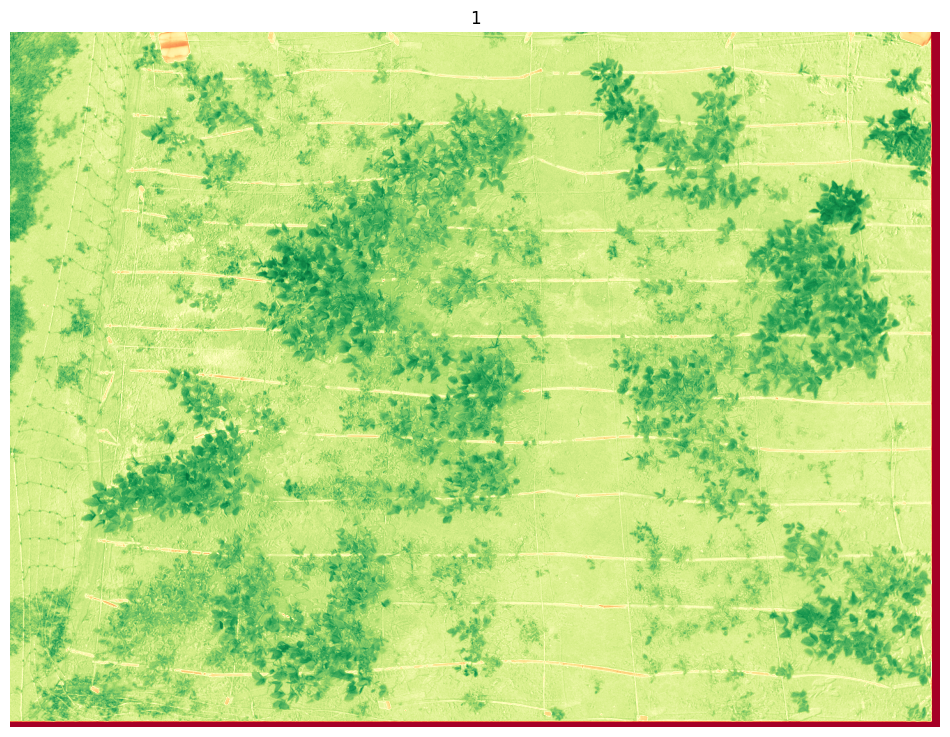

In [ ]:
pimp.graficar_imagenes(num_filas= 1, num_columnas= 1, titulos= "1",tipo="ndvi")

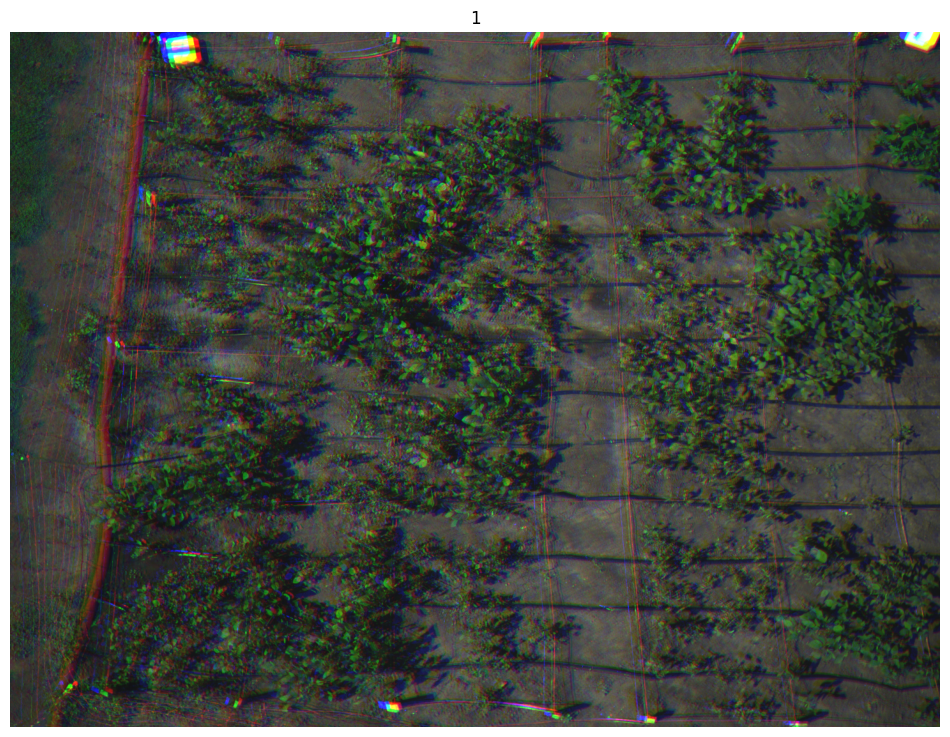

In [ ]:
pimp.graficar_imagenes(num_filas= 1, num_columnas= 1, titulos= "1",tipo="cruda")

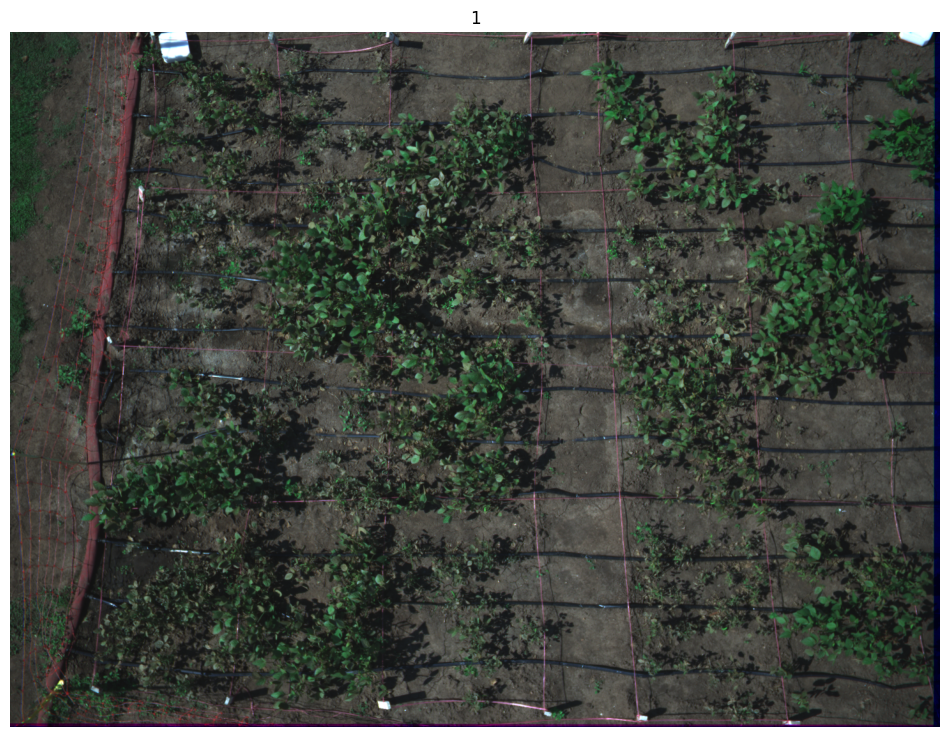

In [ ]:
pimp.graficar_imagenes(num_filas= 1, num_columnas= 1, titulos= "1",tipo="alineada")

aca hay que poner el nombre de donde queda amlancenado l resultado de ndvi, por eso genere una variable aparte arriba "resultados_ndvi_c" "resultados_ndvi_"

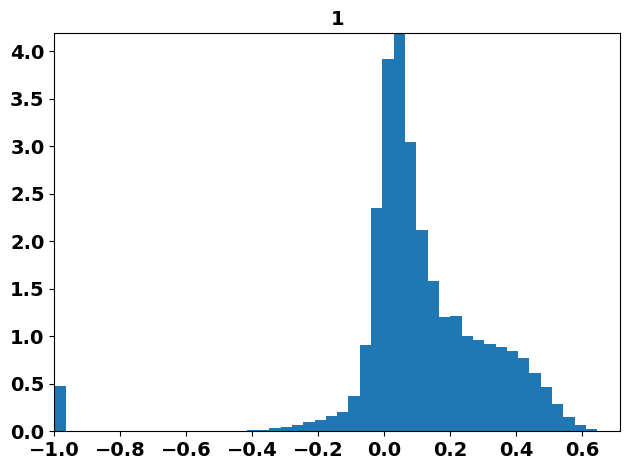

In [ ]:
pimp.graficar_histobox_ndvi(titulos = ['1'], num_filas=1, num_columnas=1, tipo_grafico='histograma')

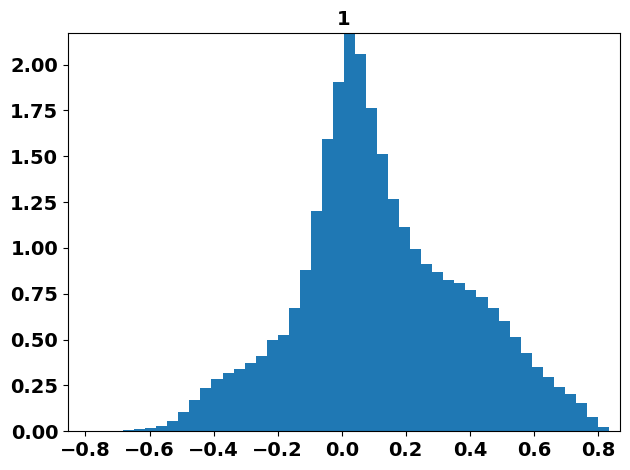

In [ ]:
pimp.graficar_histobox_ndvi(resultados_ndvi_c, titulos = ['1'], num_filas=1, num_columnas=1, tipo_grafico='histograma')

Para el caso de los boxplot igual, se debe colocar el nombr de la variable donde se alamcena el resultado "resultados_ndvi_c"

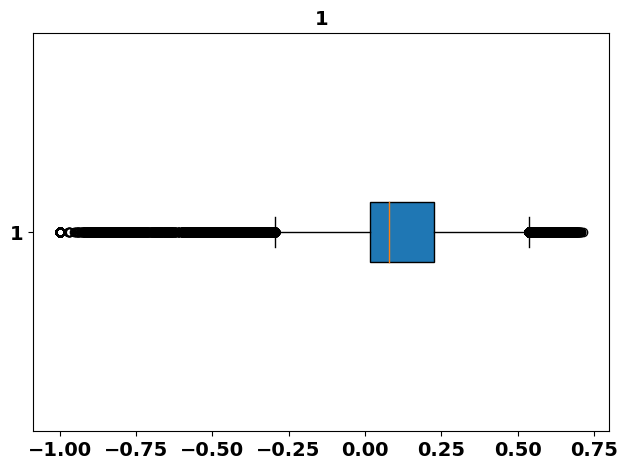

In [ ]:
pimp.graficar_histobox_ndvi(titulos=  ['1'], num_filas=1, num_columnas=1, tipo_grafico='boxplot')

Este metodo consiste en recortar una imagen NDVI en varias parcelas utilizando las coordenadas especificadas en la lista coordenadas_recortes. Cada conjunto de coordenadas en esta lista representa las coordenadas (x1, y1, x2, y2) de un rectángulo que delimita una región de interés en la imagen original. Estas coordenadas definen las esquinas superior izquierda (x1, y1) y la esquina inferior derecha (x2, y2) del rectángulo.
El método $\texttt{recortar_imagen}$ recibe como entrada el índice de la imagen en la cual se realizarán los recortes y las coordenadas de recorte, y devuelve una lista de imágenes recortadas, una para cada conjunto de coordenadas especificado. Cada imagen recortada corresponde a una parcela específica dentro de la imagen original, definida por las coordenadas proporcionadas.

In [ ]:
coordenadas_recortes = [
    (210, 0, 430, 240),
    (420, 0, 600, 260),
    (590, 0, 830, 260),
    (920, 0, 1140, 260) ,
    (1130, 0, 1320, 260) ,
    (200, 240, 410, 500),
    (400, 240, 600, 510),
    (590, 230, 840, 520),
    (920, 240, 1170, 530) ,
    (1150, 240,1400, 540) ,
    (150, 480, 390, 795),
    (400, 500, 600, 760),
    (590, 500, 840, 750),
    (940, 520, 1190, 730)  ,
    (1160, 520, 1400, 750 ) ,
    (140, 800, 340, 1050),
    (340, 770, 600, 1060),
    (580, 750, 860, 1060),
    (980, 750, 1198, 1070) ,
    (1190, 750, 1420, 1070)]
indice_imagen= 0
parcelas_ndvi = pimp.recortar_imagen(indice_imagen, coordenadas_recortes, tipo='cruda')

No se encontraron imágenes del tipo 'cruda'.


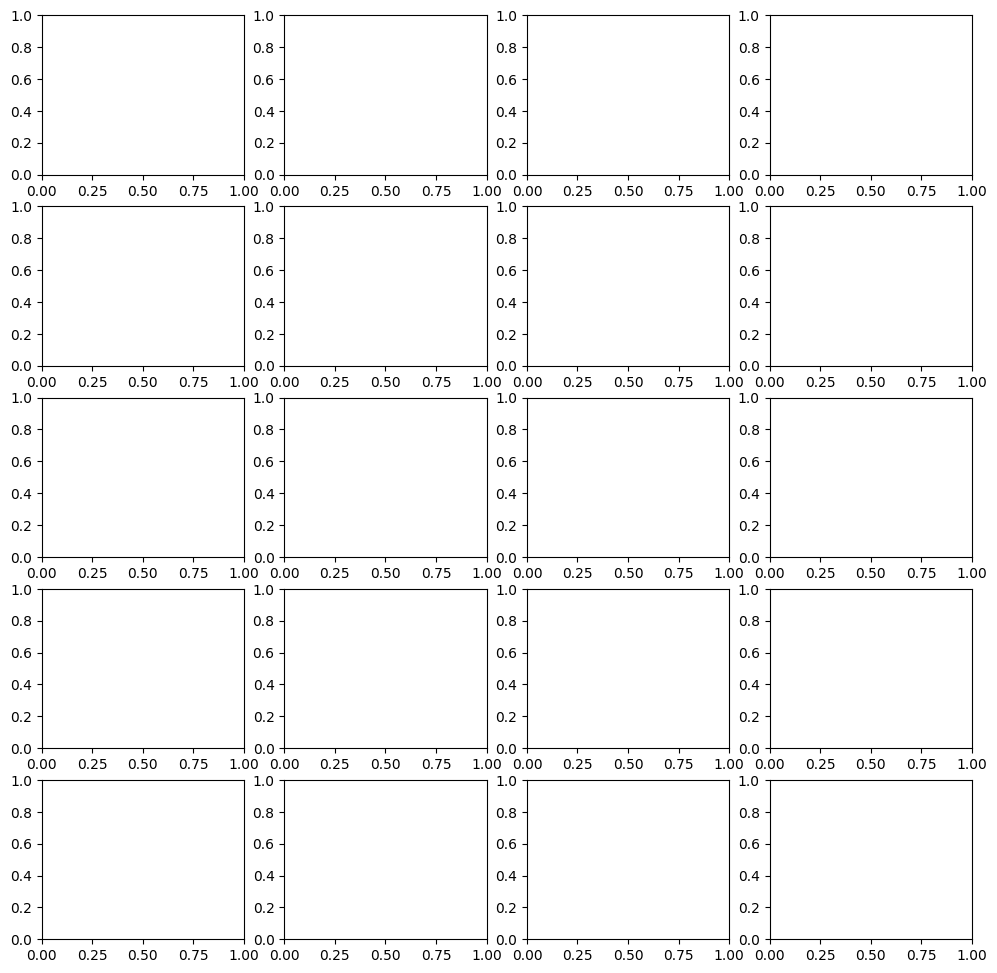

In [ ]:
titulos = [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,2,2,2,2,2]
pimp.grafica_parcelas(parcelas = parcelas_ndvi, titulos= titulos, tipo="cruda", num_filas=5, num_columnas=4, figsize=(12, 12))

In [ ]:
coordenadas_recortes = [
    (210, 0, 430, 240),
    (420, 0, 600, 260),
    (590, 0, 830, 260),
    (920, 0, 1140, 260) ,
    (1130, 0, 1320, 260) ,
    (200, 240, 410, 500),
    (400, 240, 600, 510),
    (590, 230, 840, 520),
    (920, 240, 1170, 530) ,
    (1150, 240,1400, 540) ,
    (150, 480, 390, 795),
    (400, 500, 600, 760),
    (590, 500, 840, 750),
    (940, 520, 1190, 730)  ,
    (1160, 520, 1400, 750 ) ,
    (140, 800, 340, 1050),
    (340, 770, 600, 1060),
    (580, 750, 860, 1060),
    (980, 750, 1198, 1070) ,
    (1190, 750, 1420, 1070)]
indice_imagen= 0
parcelas_ndvi = pimp.recortar_imagen(indice_imagen, coordenadas_recortes, tipo='alineada')

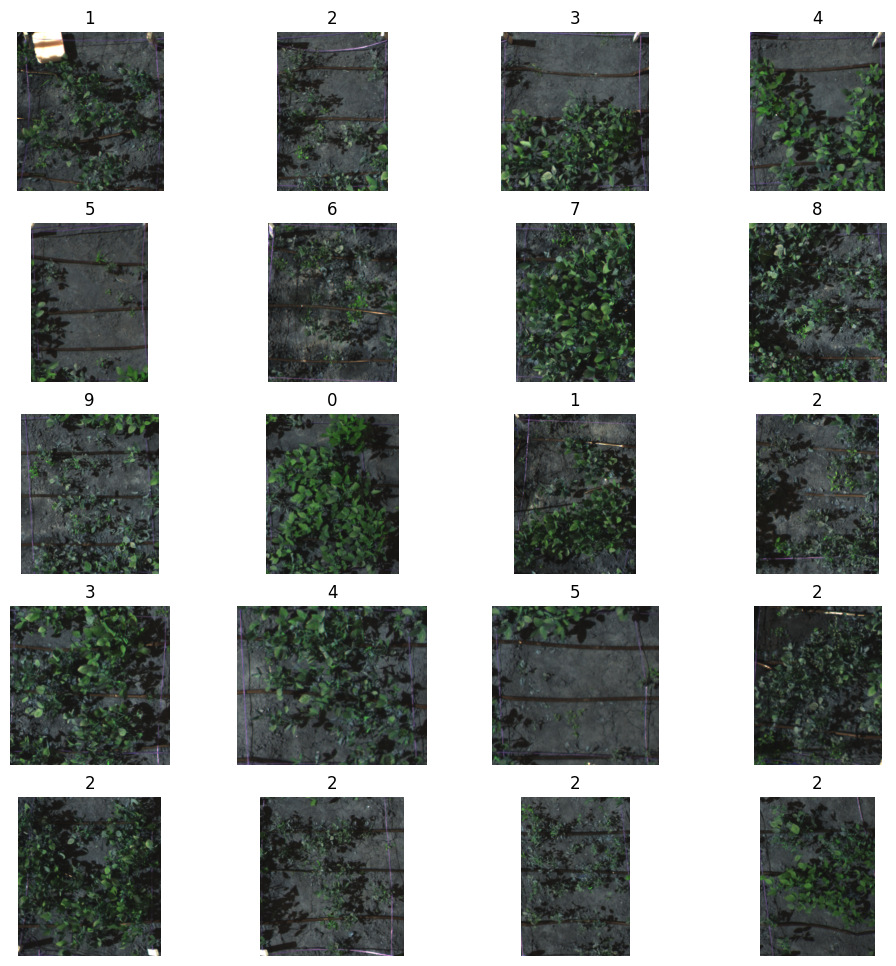

In [ ]:

titulos = [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,2,2,2,2,2]
pimp.grafica_parcelas(parcelas = parcelas_ndvi, titulos= titulos, tipo="alineada", num_filas=5, num_columnas=4, figsize=(12, 12))

In [ ]:
coordenadas_recortes = [
    (210, 0, 430, 240),
    (420, 0, 600, 260),
    (590, 0, 830, 260),
    (920, 0, 1140, 260) ,
    (1130, 0, 1320, 260) ,
    (200, 240, 410, 500),
    (400, 240, 600, 510),
    (590, 230, 840, 520),
    (920, 240, 1170, 530) ,
    (1150, 240,1400, 540) ,
    (150, 480, 390, 795),
    (400, 500, 600, 760),
    (590, 500, 840, 750),
    (940, 520, 1190, 730)  ,
    (1160, 520, 1400, 750 ) ,
    (140, 800, 340, 1050),
    (340, 770, 600, 1060),
    (580, 750, 860, 1060),
    (980, 750, 1198, 1070) ,
    (1190, 750, 1420, 1070)]
indice_imagen= 0
parcelas_ndvi = pimp.recortar_imagen(indice_imagen, coordenadas_recortes, tipo='ndvi')

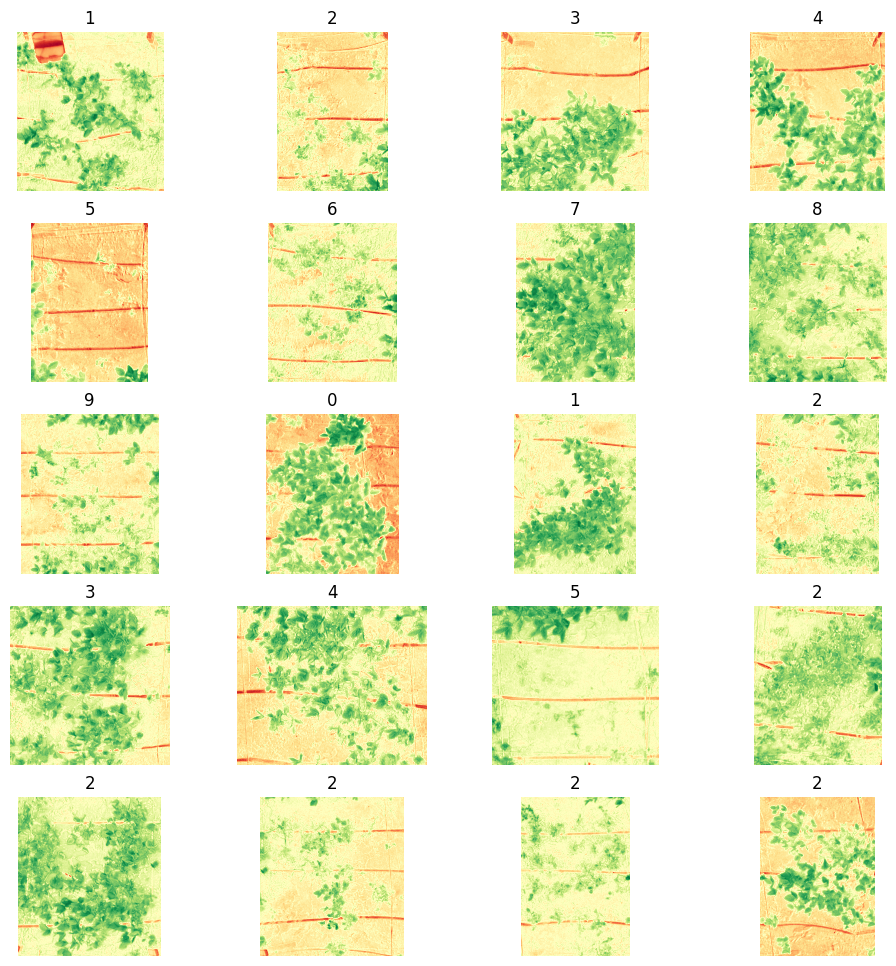

In [ ]:

titulos = [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,2,2,2,2,2]
pimp.grafica_parcelas(parcelas = parcelas_ndvi, titulos= titulos, tipo="ndvi", num_filas=5, num_columnas=4, figsize=(12, 12))

In [ ]:
x= [14.43 , 11.93 , 19.83, 16.00, 6.14, 7.67, 24.72, 18.47, 12.32, 20.59, 20.27, 9.33, 16.25, 11.29, 2.83, 29.08, 26.84, 11.40, 17.57, 14.24]
y= [1.65, 1.07, 2.27, 2.46, 0.53, 0.64, 3.46, 1.89, 1.35, 3.35, 3.15, 1.07, 2.45, 1.44, 0.17, 2.88, 3.61, 1.08, 1.39, 2.20]

print(len(x))
resultados = pimp.filtrar_pixeles(parcelas_ndvi, x=x,y=y, umbral=0.2)

20


In [ ]:
print(resultados)

        Cantidad_Pixeles_Mayor_0.2  Media_Pixeles_Mayor_0.2  \
Indice                                                        
1                              446                 0.236996   
2                              499                 0.239516   
3                              518                 0.238212   
4                              330                 0.228734   
5                              321                 0.242484   
6                             1252                 0.243179   
7                             1274                 0.246867   
8                             1422                 0.246670   
9                             1203                 0.241872   
10                             451                 0.239285   
11                            1483                 0.255759   
12                            1239                 0.244615   
13                            1415                 0.245530   
14                            1250                 0.24

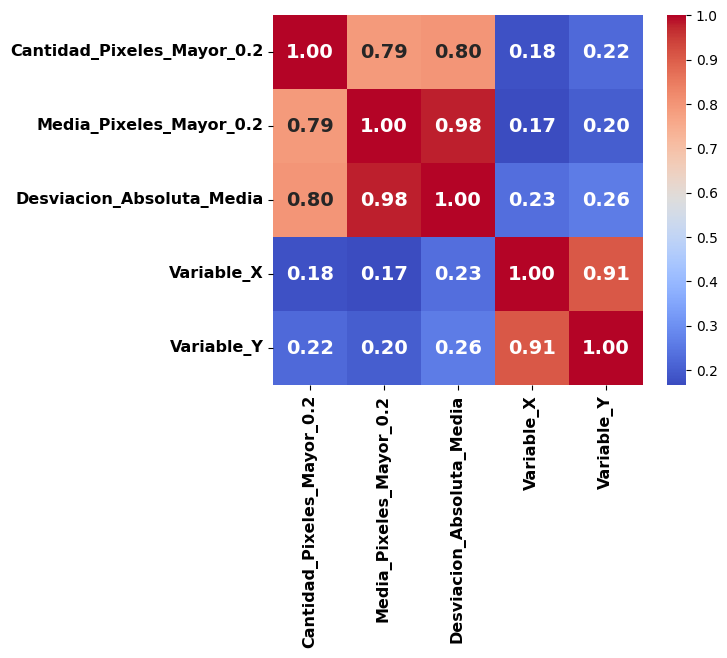

In [ ]:
pimp.graficar_correlacion(resultados)